In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

In [20]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DeepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
accuracy_history = []
epochs = 15

for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracy_history.append(accuracy)
    print(f"Epoch {epoch+1}/{epochs} - Test Accuracy: {accuracy:.2f}%")

Epoch 1/15 - Test Accuracy: 99.21%
Epoch 2/15 - Test Accuracy: 99.10%
Epoch 3/15 - Test Accuracy: 99.29%
Epoch 4/15 - Test Accuracy: 99.51%
Epoch 5/15 - Test Accuracy: 99.47%
Epoch 6/15 - Test Accuracy: 99.53%
Epoch 7/15 - Test Accuracy: 99.53%
Epoch 8/15 - Test Accuracy: 99.54%
Epoch 9/15 - Test Accuracy: 99.53%
Epoch 10/15 - Test Accuracy: 99.56%
Epoch 11/15 - Test Accuracy: 99.59%
Epoch 12/15 - Test Accuracy: 99.54%
Epoch 13/15 - Test Accuracy: 99.59%
Epoch 14/15 - Test Accuracy: 99.65%
Epoch 15/15 - Test Accuracy: 99.66%


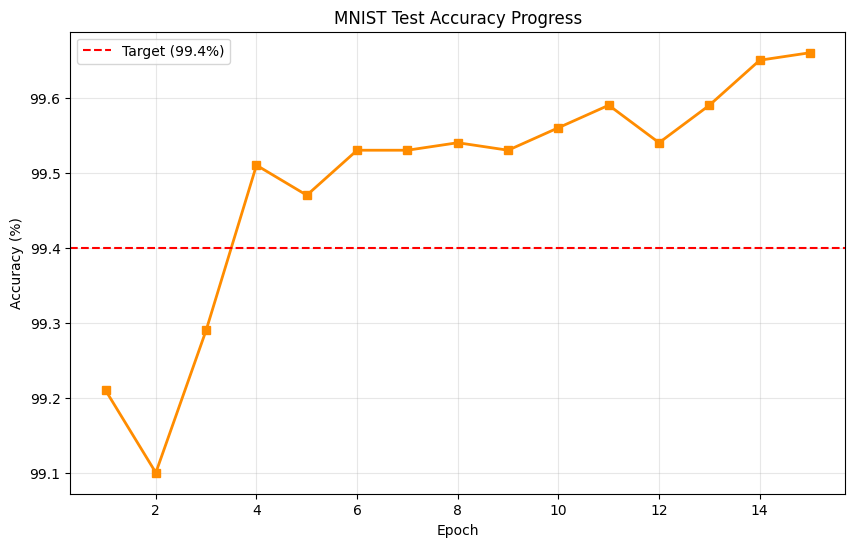

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracy_history, marker='s', color='darkorange', linewidth=2)
plt.axhline(y=99.4, color='r', linestyle='--', label='Target (99.4%)')
plt.title('MNIST Test Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
model.eval()
final_correct = 0
final_total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = 100 * final_correct / final_total
print(f"Final Model Accuracy on 10,000 Test Images: {final_accuracy:.2f}%")

/tmp/ipython-input-4025584778.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Final Model Accuracy on 10,000 Test Images: 99.66%
